In [1]:
import math
import tensorflow as tf
import numpy as np
import pylab as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

In [3]:
# Constants
NUM_FEATURES = 21
NUM_NEURONS = 10
NUM_CLASSES = 3

learning_rate = 0.01
weight_decay = 1e-6
epochs = 5000
batch_sizes = [4, 8, 16, 32, 64]
num_folds = 5
seed = 10
np.random.seed(seed)

In [4]:
# Read from CSV
train_input = np.genfromtxt('ctg_data_cleaned.csv', delimiter= ',')
trainX, train_Y = train_input[1:, :21], train_input[1:,-1].astype(int)
trainX = scale(trainX, np.min(trainX, axis=0), np.max(trainX, axis=0))

trainY = np.zeros((train_Y.shape[0], NUM_CLASSES))
trainY[np.arange(train_Y.shape[0]), train_Y-1] = 1 # one hot matrix

In [5]:
# Shuffle
print('Sample size: %d'%(trainX.shape[0]))
s = np.arange(trainX.shape[0]) # Create an index array
np.random.shuffle(s) # Shuffle the index array
trainX, trainY = trainX[s], trainY[s]

Sample size: 2126


In [6]:
# Split into 70:30 (train:test)
trainX, testX, trainY, testY = train_test_split(trainX, trainY, test_size=0.30, random_state=seed, shuffle=True)
print(trainX.shape)

(1488, 21)


In [7]:
# Create the model
x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

# Build the graph for the deep net
w1 = tf.Variable(tf.truncated_normal([NUM_FEATURES, NUM_NEURONS], stddev=1.0/math.sqrt(float(NUM_FEATURES))), name='w1')
b1 = tf.Variable(tf.zeros([NUM_NEURONS]), name='b1')
hidden_relu = tf.nn.relu(tf.matmul(x, w1) + b1, name='relu')

w2 = tf.Variable(tf.truncated_normal([NUM_NEURONS, NUM_CLASSES], stddev=1.0/math.sqrt(float(NUM_NEURONS))), name='w2')
b2  = tf.Variable(tf.zeros([NUM_CLASSES]), name='b2')
logits  = tf.matmul(hidden_relu, w2) + b2

# Apply Softmax activation function to output
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)

# Loss function with L2 Regularization with b = 10^-6
loss1 = tf.reduce_mean(cross_entropy)
regularizers = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2)
loss = tf.reduce_mean(loss1 + weight_decay * regularizers)

# Create the gradient descent optimizer with the given learning rate.
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1)), tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

In [8]:
# Main
all_cv_acc = []

# Split dataset into number of folds
kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
exp = 1

# For each batch size (4, 8 ,16, 32, 64)
for b in batch_sizes:
    print('================= Batch Size: %d =================' %b)
    batch_acc = []

    # For each fold (CV)
    for train_index, test_index in kf.split(trainX):
        fTrainX, fTestX = trainX[train_index], trainX[test_index]
        fTrainY, fTestY = trainY[train_index], trainY[test_index]

        # Run experiment
        with tf.Session() as sess:
            print('Experiment %d of %d: ' %(exp, num_folds))
            sess.run(tf.global_variables_initializer())

            exp_train_acc = []
            exp_test_acc = []

            # For each epoch
            for e in tqdm(range(epochs)):
                epoch_train_acc = []

                # Run mini-batch
                for start, end in zip(range(0, len(fTrainX), b), range(b, len(fTrainX), b)):
                    train_op.run(feed_dict={x: fTrainX[start:end], y_: fTrainY[start:end]})
                    epoch_train_acc.append(accuracy.eval(feed_dict={x: fTrainX[start:end], y_: fTrainY[start:end]}))

                exp_train_acc.append(np.mean(np.array(epoch_train_acc)))
                exp_test_acc.append(accuracy.eval(feed_dict={x: fTestX, y_: fTestY}))

#                 if e % 100 == 0:
#                     print('Iter: %d' %e, ' | ', 'Train acc: %g' %exp_train_acc[e], ' | ', 'Test acc: %g' %exp_test_acc[e])

        batch_acc.append(exp_test_acc)
        exp += 1
        
    # After all experiments are completed, compute mean
    all_cv_acc.append(np.mean(np.array(batch_acc), axis=0))
    print()

================= Batch Size: 4 =================
Experiment 1 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [33:46<00:00,  2.47it/s]


Experiment 2 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [33:31<00:00,  2.49it/s]


Experiment 3 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [33:55<00:00,  2.46it/s]


Experiment 4 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [33:53<00:00,  2.46it/s]


Experiment 5 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [33:52<00:00,  2.46it/s]



================= Batch Size: 8 =================
Experiment 6 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [16:51<00:00,  4.94it/s]


Experiment 7 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [17:08<00:00,  4.86it/s]


Experiment 8 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [16:51<00:00,  4.94it/s]


Experiment 9 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [17:08<00:00,  4.86it/s]


Experiment 10 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [17:00<00:00,  4.90it/s]



================= Batch Size: 16 =================
Experiment 11 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [08:31<00:00,  9.78it/s]


Experiment 12 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [08:32<00:00,  9.76it/s]


Experiment 13 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [08:37<00:00,  9.66it/s]


Experiment 14 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [08:34<00:00,  9.73it/s]


Experiment 15 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [08:42<00:00,  9.58it/s]



================= Batch Size: 32 =================
Experiment 16 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:20<00:00, 19.17it/s]


Experiment 17 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:21<00:00, 19.10it/s]


Experiment 18 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:16<00:00, 19.52it/s]


Experiment 19 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:21<00:00, 19.14it/s]


Experiment 20 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:17<00:00, 19.45it/s]



================= Batch Size: 64 =================
Experiment 21 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:06<00:00, 39.42it/s]


Experiment 22 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:07<00:00, 39.09it/s]


Experiment 23 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:08<00:00, 38.77it/s]


Experiment 24 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:07<00:00, 39.12it/s]


Experiment 25 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:09<00:00, 38.57it/s]


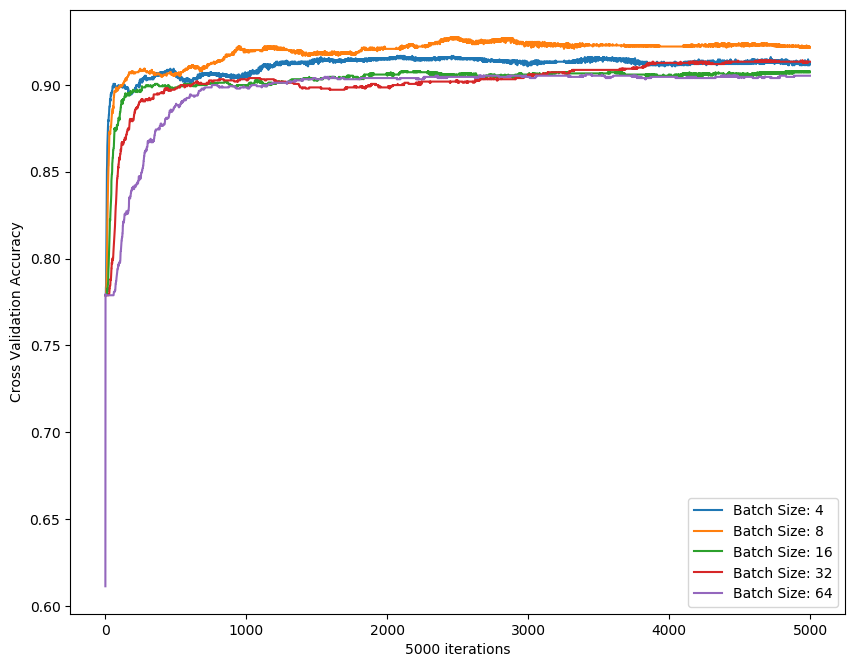

In [12]:
# Plot curves
plt.figure(1, figsize=(10, 8), dpi= 100)
# plt.title('Batch size: %d' %batch_size)

for b, i in zip(batch_sizes, np.arange(len(batch_sizes))):
    plt.plot(range(epochs), all_cv_acc[i], label='Batch Size: %d' %b)

plt.xlabel(str(epochs) + ' iterations')
plt.ylabel('Cross Validation Accuracy')
plt.legend()
# plt.savefig('PartA_Qn2a_BatchSizes.png')
plt.show()